<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** Sergio Daniel Dueñas Godinez y Hector Cesar Ornelas León.

**Fecha:** 15 de Febrero del 2024.

**Expediente** : 739300 y 738146
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/SergioDuenass/Tarea3_SDDUENAS_HCORNELAS

# Tarea 3: Clase 7

## Enunciado de tarea
### Tarea 3


Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado. Algo como lo siguiente:

~~~
class LinearForecast:
    def __init__(self, atributos_del_contructor):
        
    def adf_test(self):
        
    def plot_acf_pac(self):
        
        .
        .
        .
~~~

Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase.

Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos:
https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true

### Ejercicio 1: (enunciado) Transcribirlo

Código de solución estudiante 1

In [1]:
# Código de solución estudiante 1
class LinearForecast:
    def __init__(self, atributos_del_contructor):
        pass
        
    def adf_test(self):
        pass
        
    def plot_acf_pac(self):
        pass
        

Código de solución estudiante 2

## Ejercicio 1

In [2]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import power_transform
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
class LinearForecast:

    def __init__(self, data):
        self.data = data

    def setTimeSeries(self, target, dateColumn = 'date'):
        
        timeseries = self.data[[dateColumn, target]]
        timeseries.columns = ['date', 'y']
        timeseries['date'] = pd.to_datetime(timeseries['date'])
        timeseries = timeseries.set_index('date').resample('M').mean()
        self.timeseries = timeseries
        self.toUse = timeseries
        return self.timeseries.tail()

    def setTimeSeriesSlice(self, fraction = 400):
        
        self.slice = fraction
        self.fraction = self.timeseries[:fraction]
        self.toUse = self.fraction

    # Visualizar serie de tiempo
    def plotTimeSeries(self):
        
        return self.toUse.plot()

    #ADF
    def adf_test(self, useSelf = True, extra = ''):
        
        print("Results of Dickey-Fuller Test:")
        if useSelf:
            series = self.timeseries
        else:
            series = extra
        dftest = adfuller(series, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)
        
        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")

    # Graficar ACF y PACF
    def plot_acf_pacf(self, withDiff = 0, kwargs={'lags' : 40}, useSelf = True, extra = ''):
        
        f = plt.figure(figsize=(8,5))

        if useSelf:
            series = self.toUse
        else:
            series = extra

        for _ in range(withDiff):
            series = series.diff().dropna()

        ax1 = f.add_subplot(121)

        plot_acf(series, zero=False, ax=ax1, **kwargs)

        ax2 = f.add_subplot(122)
        plot_pacf(series, zero=False, ax=ax2, method='ols', **kwargs)

        plt.show()

    #Función para analisis de estacionalidad
    def seasonalDecompose(self, seasonality):
        
        self.seasonality = seasonality
        data1 = self.timeseries.copy()
        periods_seasonality = self.seasonality

        stl_kwargs = {"seasonal_deg": 0} 
        model = MSTL(data1, periods=periods_seasonality, stl_kwargs=stl_kwargs)
        res2 = model.fit()
        self.res2 = res2

        # Gráfica de descomposición
        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

        res2.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observed')

        res2.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Trend')

        res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
        ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

        res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
        ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

        res2.resid.plot(ax=ax[4])
        ax[4].set_ylabel('Residual')

        fig.tight_layout()

        ax = res2.observed.to_frame('observados')[:self.slice].plot()

        res2.seasonal[:self.slice].plot(ax = ax)

    #Determinar Parámetros
    def checkStationary(self):
        
        j = {}
        for i in self.seasonality:
            h = f'seasonal_{i}'
            print(h, '\n')
            j[h] = self.res2.seasonal[h]
            self.adf_test(useSelf = False, extra = j[h])
            print('Non-differentiated')
            self.plot_acf_pacf(useSelf = False, extra = j[h])
            print('Differentiated')
            self.plot_acf_pacf(withDiff=1, useSelf = False, extra = j[h])
            print('\n\n\n')
        self.j = j

    #Componente no estacional
    def nonStationalComponent(self, seasonality):
        
        self.adf_test(useSelf=False, extra=self.res2.observed)
        non_seasonal = self.res2.observed - self.res2.seasonal[f'seasonal_{seasonality}']
        non_seasonal.plot()
        self.adf_test(useSelf=False, extra = non_seasonal)
        print('Non-differentiated')
        self.plot_acf_pacf(useSelf = False, extra = non_seasonal)
        print('Differentiated')
        self.plot_acf_pacf(withDiff=1, useSelf = False, extra = non_seasonal)
        print('Differentiated x2')
        self.plot_acf_pacf(withDiff=2, useSelf = False, extra = non_seasonal)
        self.non_seasonal = non_seasonal
        self.chosenSeasonality = seasonality

    #Combinaciones de parámetros
    def sarimaxParameters(self, p, d, q, P, D, Q, t=['n', 'c', 't', 'ct']):
        
        params_no_estacionales = list(itertools.product(p, d, q))
        params_estacionales = [(x[0], x[1], x[2], self.chosenSeasonality) for x in list(itertools.product(P, D, Q))]

        #Diferentes conmbinaciones
        sarimax_params = list(itertools.product(params_no_estacionales, params_estacionales, t))
        self.sarimax_params = sarimax_params

    #Escalamiento de datos
    def scaleData(self):
        
        vals = power_transform(self.timeseries['y'].to_numpy().reshape(-1, 1), method='box-cox')
        self.scaledData = vals
    
    #Encontrar parámetros óptimos
    def findParams(self):
        
        self.scaleData()
        resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'], index = np.arange(0, 11))

        print(f'Trying out {len(self.sarimax_params)} posible combinations')

        i = 0
        for par_no_season, par_season, trend in self.sarimax_params:

            mod = SARIMAX(
                endog= self.scaledData,
                trend= trend,
                order= par_no_season,
                seasonal_order= par_season
            )
            results = mod.fit()

            print(f'Model done for params: {par_no_season}, {par_season}, {trend}')

            resultados.loc[i, 'params'] = str((par_no_season, par_season, trend))
            resultados.loc[i, 'AIC'] = results.aic
            resultados.loc[i, 'BIC'] = results.bic
            resultados.loc[i, 'LLF'] = results.llf
            i += 1

        self.resultadosParams = resultados
        return self.resultadosParams

    #Entrenar con los mejores parámetros
    def sarimaxModel(self, no_season, season, trend):
        
        model = SARIMAX(
                endog= self.scaledData,
                trend= trend,
                order= no_season,
                seasonal_order= season,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
        results = model.fit()
        self.sarimax = results
        return results.summary()

    #Predicción
    def prediction(self, size):
        
        end = len(self.timeseries)
        start = end-size
        actual = self.scaledData[start:end]
        predicted = self.sarimax.predict(start = start+1, end = end, dynamic = True)
        actual = actual.reshape(size,)
        assert actual.shape == predicted.shape

        self.actual = actual
        self.predicted = predicted

        predictions = pd.DataFrame({'actual': actual, 'predicted': predicted}, index=self.timeseries.index[start:end])

        fig, ax = plt.subplots(figsize=(12,8))
        predictions.actual.plot(ax = ax)
        predictions.predicted.plot(ax =ax)
        ax.legend(labels = ['actual', 'forecast'])

    #MAPE
    def calculate_mape(self):
        
        if not all([isinstance(self.actual, np.ndarray), isinstance(self.predicted, np.ndarray)]):
            self.actual, self.predicted = np.array(self.actual), np.array(self.predicted)


        self.mape =  round(np.mean(np.abs((self.actual - self.predicted) / self.actual)) * 100, 2)

    #MAD
    def calculate_mad(self):
        
        if not all([isinstance(self.actual, np.ndarray), isinstance(self.predicted, np.ndarray)]):
            self.actual, self.predicted = np.array(self.actual), np.array(self.predicted)


        self.mad =  round(np.mean(np.abs(self.actual - self.predicted)) * 100, 2)

    #Métricas de error
    def errors(self):
        
        self.calculate_mape()
        self.calculate_mad()
        print(f'MAPE: {self.mape} \n MAD: {self.mad}')

## Ejercicio 2

In [4]:
data = pd.read_excel('https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true')
data

,Unnamed: 0,date,year,month,day,hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),Energy (kWh)
0,6,1990-01-01,1990,Jan,Mon,6,234,503,78,12.1406,9.7,498.632
1,7,1990-01-01,1990,Jan,Mon,7,448,723,91,13.3250,10.1,720.409
2,8,1990-01-01,1990,Jan,Mon,8,699,959,71,13.3094,9.3,946.154
3,9,1990-01-01,1990,Jan,Mon,9,880,1016,73,13.9375,9.1,987.273
4,10,1990-01-01,1990,Jan,Mon,10,1009,1031,85,14.1141,8.0,1000.230
...,...,...,...,...,...,...,...,...,...,...,...,...
96995,8750,2014-12-31,2014,Dec,Wed,14,903,971,94,14.4875,8.8,925.713
96996,8751,2014-12-31,2014,Dec,Wed,15,746,950,76,14.2563,8.8,920.625
96997,8752,2014-12-31,2014,Dec,Wed,16,545,865,69,13.2500,8.6,854.471
96998,8753,2014-12-31,2014,Dec,Wed,17,308,599,80,13.0094,9.0,605.375


In [5]:
ts = data.copy()
ts['date'] = ts.apply(lambda x: x['date'] + pd.Timedelta(x['hour'], 'h'), axis = 1)
ts.head()

,Unnamed: 0,date,year,month,day,hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),Energy (kWh)
0,6,1990-01-01 06:00:00,1990,Jan,Mon,6,234,503,78,12.1406,9.7,498.632
1,7,1990-01-01 07:00:00,1990,Jan,Mon,7,448,723,91,13.3250,10.1,720.409
2,8,1990-01-01 08:00:00,1990,Jan,Mon,8,699,959,71,13.3094,9.3,946.154
3,9,1990-01-01 09:00:00,1990,Jan,Mon,9,880,1016,73,13.9375,9.1,987.273
4,10,1990-01-01 10:00:00,1990,Jan,Mon,10,1009,1031,85,14.1141,8.0,1000.230


In [6]:
LF = LinearForecast(ts)
LF.setTimeSeries('Energy (kWh)')

C:\Users\hecto\AppData\Local\Temp\ipykernel_500\3579077491.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeseries['date'] = pd.to_datetime(timeseries['date'])


,y
date,
2014-08-31,367.172808
2014-09-30,386.856567
2014-10-31,381.547674
2014-11-30,398.744335
2014-12-31,442.269996


<Axes: xlabel='date'>

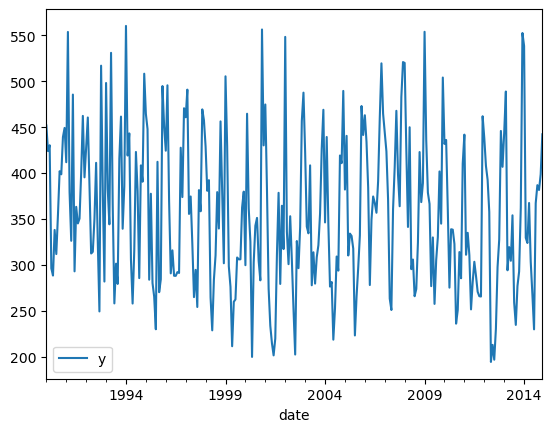

In [7]:
LF.plotTimeSeries()

<Axes: xlabel='date'>

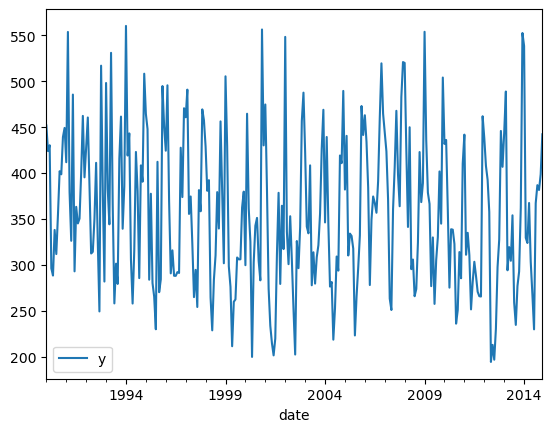

In [8]:
LF.setTimeSeriesSlice()
LF.plotTimeSeries()

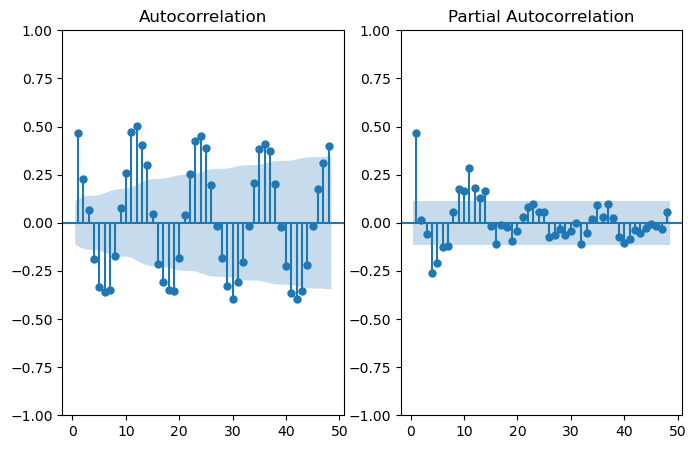

In [9]:
LF.plot_acf_pacf(kwargs={'lags': 48})

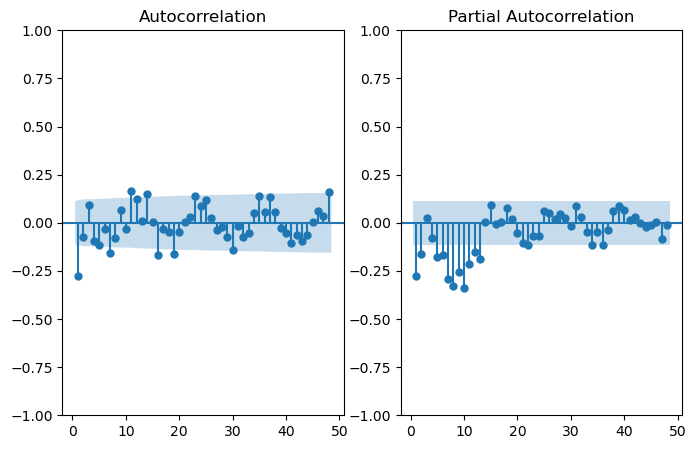

In [10]:
LF.plot_acf_pacf(1, kwargs={'lags': 48})

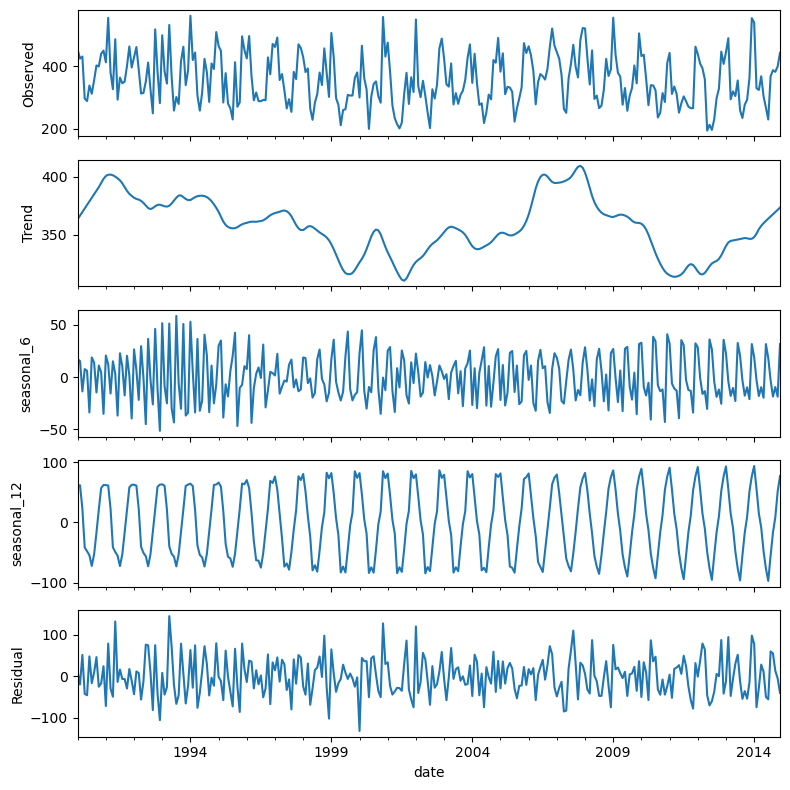

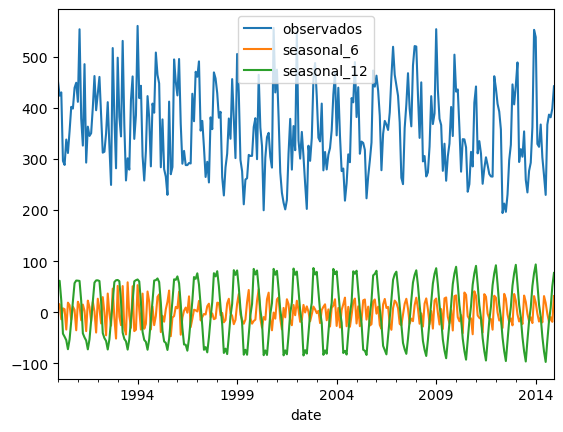

In [11]:
LF.seasonalDecompose((6, 12))

seasonal_6 

Results of Dickey-Fuller Test:
Test Statistic                -9.451841e+00
p-value                        4.594080e-16
#Lags Used                     1.600000e+01
Number of Observations Used    2.830000e+02
Critical Value (1%)           -3.453670e+00
Critical Value (5%)           -2.871808e+00
Critical Value (10%)          -2.572241e+00
dtype: float64
Stationary
Non-differentiated


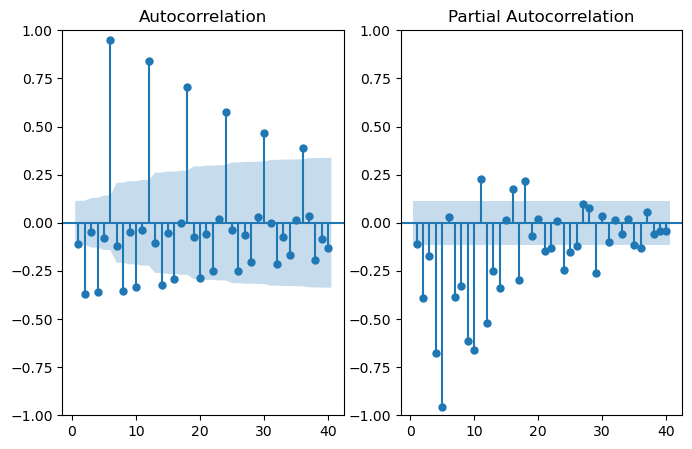

Differentiated


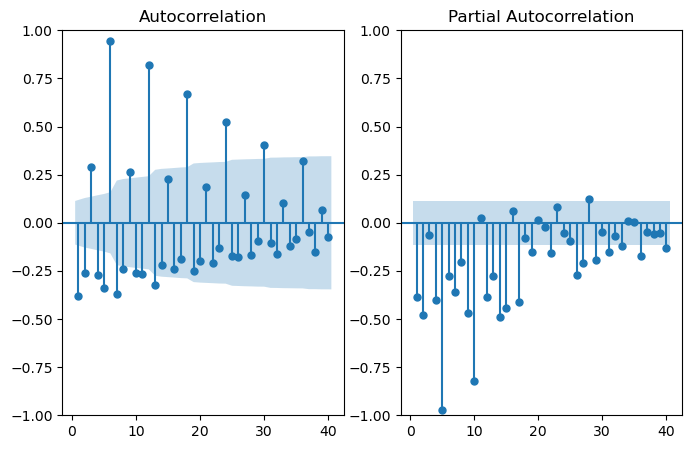





seasonal_12 

Results of Dickey-Fuller Test:
Test Statistic                 -29.256349
p-value                          0.000000
#Lags Used                      16.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64
Stationary
Non-differentiated


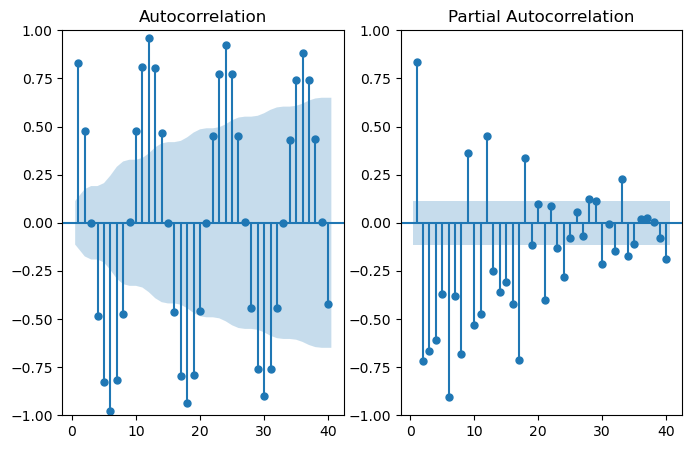

Differentiated


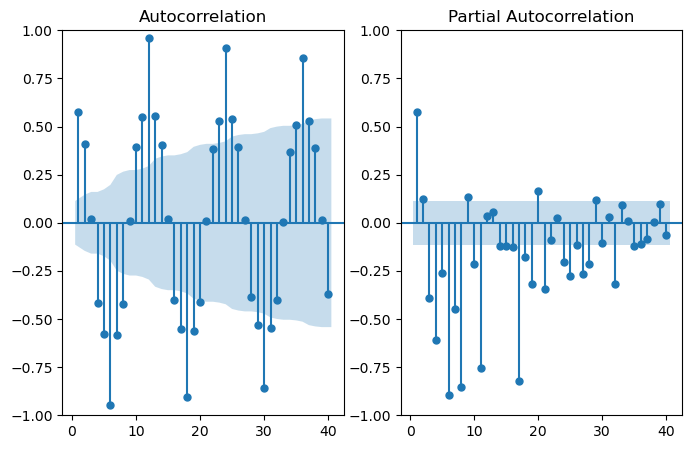

In [12]:
LF.checkStationary()

Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary
Results of Dickey-Fuller Test:
Test Statistic                  -2.287739
p-value                          0.175953
#Lags Used                      15.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64
Non-stationary
Non-differentiated


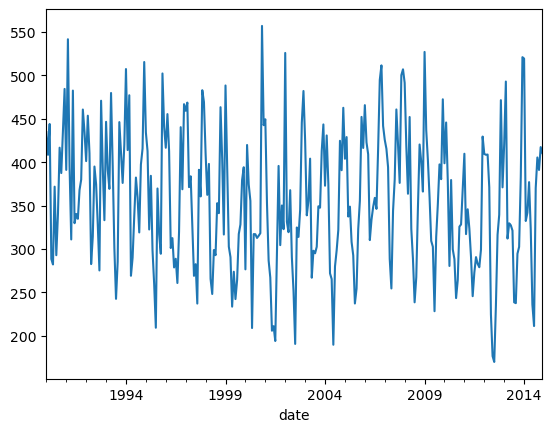

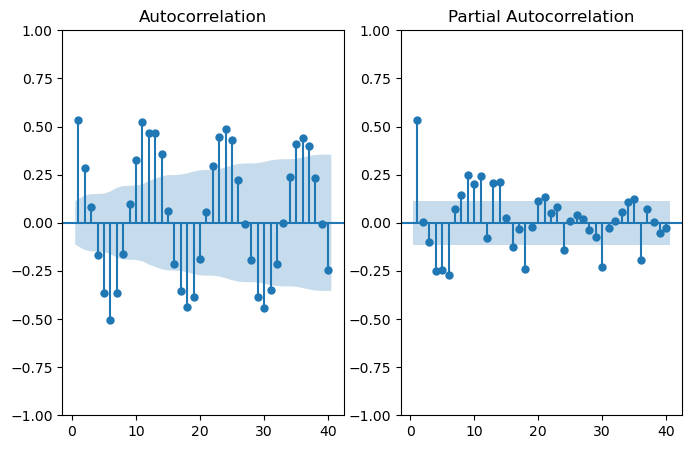

Differentiated


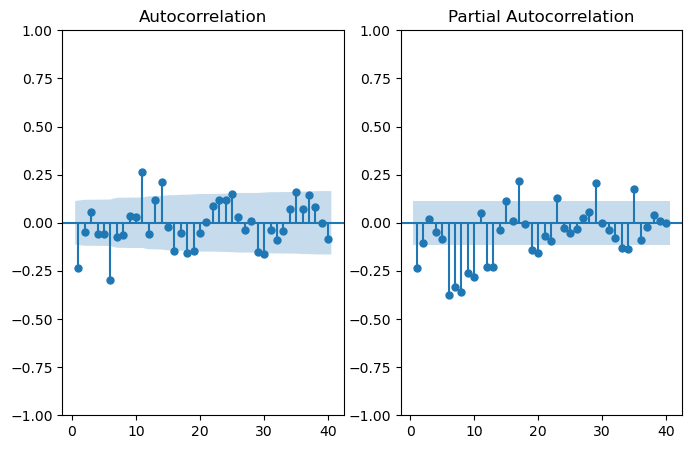

Differentiated x2


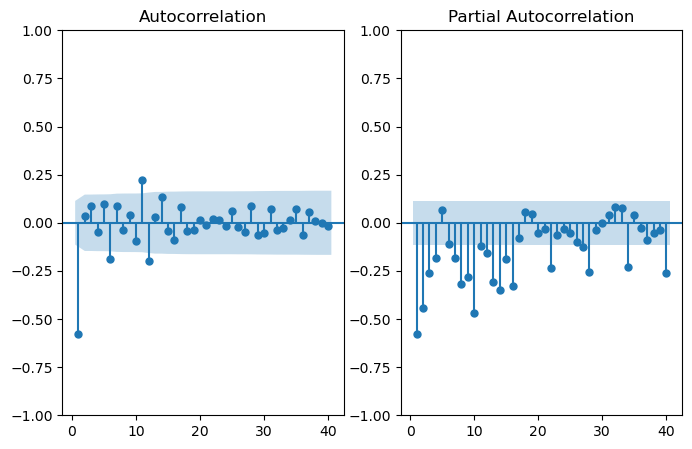

In [13]:
LF.nonStationalComponent(6)

Results of Dickey-Fuller Test:
Test Statistic                  -5.001408
p-value                          0.000022
#Lags Used                      16.000000
Number of Observations Used    282.000000
Critical Value (1%)             -3.453754
Critical Value (5%)             -2.871844
Critical Value (10%)            -2.572261
dtype: float64
Stationary


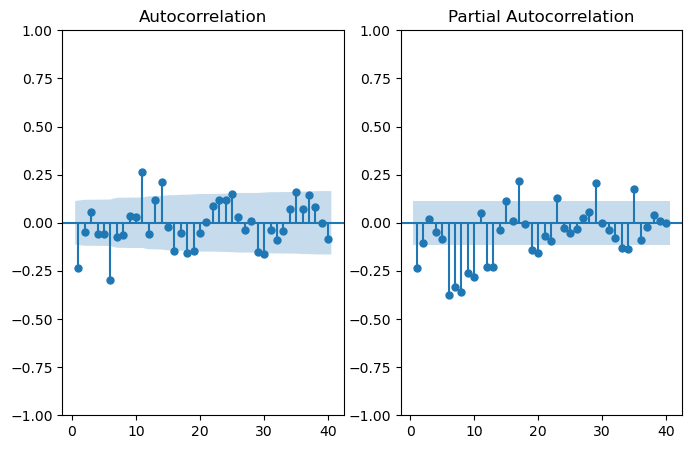

In [14]:
LF.adf_test(False, LF.non_seasonal.diff().dropna())
LF.plot_acf_pacf(1, {'lags': 40}, False, LF.non_seasonal)

In [26]:
p = [0, 1, 2]
d = [1]
q = [0, 1, 2]
P = [0 ,1, 2]
D = [0]
Q = [0, 1, 2]
LF.sarimaxParameters(p, d, q, P, D, Q)

In [27]:
optparams = LF.findParams().sort_values(by=['AIC'], ascending=True)
optparams

Trying out 324 posible combinations
Model done for params: (0, 1, 0), (0, 0, 0, 6), n
Model done for params: (0, 1, 0), (0, 0, 0, 6), c
Model done for params: (0, 1, 0), (0, 0, 0, 6), t
Model done for params: (0, 1, 0), (0, 0, 0, 6), ct
Model done for params: (0, 1, 0), (0, 0, 1, 6), n
Model done for params: (0, 1, 0), (0, 0, 1, 6), c
Model done for params: (0, 1, 0), (0, 0, 1, 6), t
Model done for params: (0, 1, 0), (0, 0, 1, 6), ct
Model done for params: (0, 1, 0), (0, 0, 2, 6), n
Model done for params: (0, 1, 0), (0, 0, 2, 6), c
Model done for params: (0, 1, 0), (0, 0, 2, 6), t
Model done for params: (0, 1, 0), (0, 0, 2, 6), ct
Model done for params: (0, 1, 0), (1, 0, 0, 6), n
Model done for params: (0, 1, 0), (1, 0, 0, 6), c
Model done for params: (0, 1, 0), (1, 0, 0, 6), t
Model done for params: (0, 1, 0), (1, 0, 0, 6), ct
Model done for params: (0, 1, 0), (1, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (1, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (1, 0, 1, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (1, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (1, 0, 2, 6), c
Model done for params: (0, 1, 0), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (1, 0, 2, 6), ct
Model done for params: (0, 1, 0), (2, 0, 0, 6), n
Model done for params: (0, 1, 0), (2, 0, 0, 6), c
Model done for params: (0, 1, 0), (2, 0, 0, 6), t
Model done for params: (0, 1, 0), (2, 0, 0, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (2, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (2, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (2, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (2, 0, 1, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (2, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (2, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (2, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (2, 0, 2, 6), ct
Model done for params: (0, 1, 1), (0, 0, 0, 6), n
Model done for params: (0, 1, 1), (0, 0, 0, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (0, 0, 0, 6), t
Model done for params: (0, 1, 1), (0, 0, 0, 6), ct
Model done for params: (0, 1, 1), (0, 0, 1, 6), n
Model done for params: (0, 1, 1), (0, 0, 1, 6), c
Model done for params: (0, 1, 1), (0, 0, 1, 6), t
Model done for params: (0, 1, 1), (0, 0, 1, 6), ct
Model done for params: (0, 1, 1), (0, 0, 2, 6), n
Model done for params: (0, 1, 1), (0, 0, 2, 6), c
Model done for params: (0, 1, 1), (0, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (0, 0, 2, 6), ct
Model done for params: (0, 1, 1), (1, 0, 0, 6), n
Model done for params: (0, 1, 1), (1, 0, 0, 6), c
Model done for params: (0, 1, 1), (1, 0, 0, 6), t
Model done for params: (0, 1, 1), (1, 0, 0, 6), ct
Model done for params: (0, 1, 1), (1, 0, 1, 6), n
Model done for params: (0, 1, 1), (1, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (1, 0, 1, 6), ct
Model done for params: (0, 1, 1), (1, 0, 2, 6), n
Model done for params: (0, 1, 1), (1, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (1, 0, 2, 6), ct
Model done for params: (0, 1, 1), (2, 0, 0, 6), n
Model done for params: (0, 1, 1), (2, 0, 0, 6), c
Model done for params: (0, 1, 1), (2, 0, 0, 6), t
Model done for params: (0, 1, 1), (2, 0, 0, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (2, 0, 1, 6), n
Model done for params: (0, 1, 1), (2, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (2, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (2, 0, 1, 6), ct
Model done for params: (0, 1, 1), (2, 0, 2, 6), n
Model done for params: (0, 1, 1), (2, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (2, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (2, 0, 2, 6), ct
Model done for params: (0, 1, 2), (0, 0, 0, 6), n
Model done for params: (0, 1, 2), (0, 0, 0, 6), c
Model done for params: (0, 1, 2), (0, 0, 0, 6), t
Model done for params: (0, 1, 2), (0, 0, 0, 6), ct
Model done for params: (0, 1, 2), (0, 0, 1, 6), n
Model done for params: (0, 1, 2), (0, 0, 1, 6), c
Model done for params: (0, 1, 2), (0, 0, 1, 6), t
Model done for params: (0, 1, 2), (0, 0, 1, 6), ct
Model done for params: (0, 1, 2), (0, 0, 2, 6), n
Model done for params: (0, 1, 2), (0, 0, 2, 6), c
Model done for params: (0, 1, 2), (0, 0, 2, 6), t
Model done for params: (0, 1, 2), (0, 0, 2, 6), ct
Model done for params: (0, 1, 2), (1, 0, 0, 6), n
Model done for params: (0, 1, 2), (1, 0, 0, 6), c
Model done for params: (0, 1, 2), (1, 0, 0, 6), t
Model done for params: (0, 1, 2), (1, 0, 0, 6), ct
Model done for params: (0, 1, 2), (1, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (1, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (1, 0, 1, 6), ct
Model done for params: (0, 1, 2), (1, 0, 2, 6), n
Model done for params: (0, 1, 2), (1, 0, 2, 6), c
Model done for params: (0, 1, 2), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (1, 0, 2, 6), ct
Model done for params: (0, 1, 2), (2, 0, 0, 6), n
Model done for params: (0, 1, 2), (2, 0, 0, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (2, 0, 0, 6), t
Model done for params: (0, 1, 2), (2, 0, 0, 6), ct
Model done for params: (0, 1, 2), (2, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (2, 0, 1, 6), c
Model done for params: (0, 1, 2), (2, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (2, 0, 1, 6), ct
Model done for params: (0, 1, 2), (2, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (2, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (2, 0, 2, 6), t
Model done for params: (0, 1, 2), (2, 0, 2, 6), ct
Model done for params: (1, 1, 0), (0, 0, 0, 6), n
Model done for params: (1, 1, 0), (0, 0, 0, 6), c
Model done for params: (1, 1, 0), (0, 0, 0, 6), t
Model done for params: (1, 1, 0), (0, 0, 0, 6), ct
Model done for params: (1, 1, 0), (0, 0, 1, 6), n
Model done for params: (1, 1, 0), (0, 0, 1, 6), c
Model done for params: (1, 1, 0), (0, 0, 1, 6), t
Model done for params: (1, 1, 0), (0, 0, 1, 6), ct
Model done for params: (1, 1, 0), (0, 0, 2, 6), n
Model done for params: (1, 1, 0), (0, 0, 2, 6), c
Model done for params: (1, 1, 0), (0, 0, 2, 6), t
Model done for params: (1, 1, 0), (0, 0, 2, 6), ct
Model done for params: (1, 1, 0), (1, 0, 0, 6), n
Model done for params: (1, 1, 0), (1, 0, 0, 6), c
Model done for params: (1, 1, 0), (1, 0, 0, 6), t
Model done for params: (1, 1, 0), (1, 0, 0, 6), ct
Model done for params: (1, 1, 0), (1, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (1, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (1, 0, 1, 6), ct
Model done for params: (1, 1, 0), (1, 0, 2, 6), n
Model done for params: (1, 1, 0), (1, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (1, 0, 2, 6), ct
Model done for params: (1, 1, 0), (2, 0, 0, 6), n
Model done for params: (1, 1, 0), (2, 0, 0, 6), c
Model done for params: (1, 1, 0), (2, 0, 0, 6), t
Model done for params: (1, 1, 0), (2, 0, 0, 6), ct
Model done for params: (1, 1, 0), (2, 0, 1, 6), n
Model done for params: (1, 1, 0), (2, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (2, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (2, 0, 1, 6), ct
Model done for params: (1, 1, 0), (2, 0, 2, 6), n
Model done for params: (1, 1, 0), (2, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (2, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (2, 0, 2, 6), ct
Model done for params: (1, 1, 1), (0, 0, 0, 6), n
Model done for params: (1, 1, 1), (0, 0, 0, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (0, 0, 0, 6), t
Model done for params: (1, 1, 1), (0, 0, 0, 6), ct
Model done for params: (1, 1, 1), (0, 0, 1, 6), n
Model done for params: (1, 1, 1), (0, 0, 1, 6), c
Model done for params: (1, 1, 1), (0, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (0, 0, 1, 6), ct
Model done for params: (1, 1, 1), (0, 0, 2, 6), n
Model done for params: (1, 1, 1), (0, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (0, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (0, 0, 2, 6), ct
Model done for params: (1, 1, 1), (1, 0, 0, 6), n
Model done for params: (1, 1, 1), (1, 0, 0, 6), c
Model done for params: (1, 1, 1), (1, 0, 0, 6), t
Model done for params: (1, 1, 1), (1, 0, 0, 6), ct
Model done for params: (1, 1, 1), (1, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (1, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (1, 0, 1, 6), ct
Model done for params: (1, 1, 1), (1, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (1, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (1, 0, 2, 6), ct
Model done for params: (1, 1, 1), (2, 0, 0, 6), n
Model done for params: (1, 1, 1), (2, 0, 0, 6), c
Model done for params: (1, 1, 1), (2, 0, 0, 6), t
Model done for params: (1, 1, 1), (2, 0, 0, 6), ct
Model done for params: (1, 1, 1), (2, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (2, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (2, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (2, 0, 1, 6), ct
Model done for params: (1, 1, 1), (2, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (2, 0, 2, 6), c
Model done for params: (1, 1, 1), (2, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (2, 0, 2, 6), ct
Model done for params: (1, 1, 2), (0, 0, 0, 6), n
Model done for params: (1, 1, 2), (0, 0, 0, 6), c
Model done for params: (1, 1, 2), (0, 0, 0, 6), t
Model done for params: (1, 1, 2), (0, 0, 0, 6), ct
Model done for params: (1, 1, 2), (0, 0, 1, 6), n
Model done for params: (1, 1, 2), (0, 0, 1, 6), c
Model done for params: (1, 1, 2), (0, 0, 1, 6), t
Model done for params: (1, 1, 2), (0, 0, 1, 6), ct
Model done for params: (1, 1, 2), (0, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (0, 0, 2, 6), c
Model done for params: (1, 1, 2), (0, 0, 2, 6), t
Model done for params: (1, 1, 2), (0, 0, 2, 6), ct
Model done for params: (1, 1, 2), (1, 0, 0, 6), n
Model done for params: (1, 1, 2), (1, 0, 0, 6), c
Model done for params: (1, 1, 2), (1, 0, 0, 6), t
Model done for params: (1, 1, 2), (1, 0, 0, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (1, 0, 1, 6), n
Model done for params: (1, 1, 2), (1, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (1, 0, 1, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (1, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (1, 0, 2, 6), c
Model done for params: (1, 1, 2), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (1, 0, 2, 6), ct
Model done for params: (1, 1, 2), (2, 0, 0, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (2, 0, 0, 6), c
Model done for params: (1, 1, 2), (2, 0, 0, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (2, 0, 0, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (2, 0, 1, 6), n
Model done for params: (1, 1, 2), (2, 0, 1, 6), c
Model done for params: (1, 1, 2), (2, 0, 1, 6), t
Model done for params: (1, 1, 2), (2, 0, 1, 6), ct
Model done for params: (1, 1, 2), (2, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (2, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (2, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (2, 0, 2, 6), ct
Model done for params: (2, 1, 0), (0, 0, 0, 6), n
Model done for params: (2, 1, 0), (0, 0, 0, 6), c
Model done for params: (2, 1, 0), (0, 0, 0, 6), t
Model done for params: (2, 1, 0), (0, 0, 0, 6), ct
Model done for params: (2, 1, 0), (0, 0, 1, 6), n
Model done for params: (2, 1, 0), (0, 0, 1, 6), c
Model done for params: (2, 1, 0), (0, 0, 1, 6), t
Model done for params: (2, 1, 0), (0, 0, 1, 6), ct
Model done for params: (2, 1, 0), (0, 0, 2, 6), n
Model done for params: (2, 1, 0), (0, 0, 2, 6), c
Model done for params: (2, 1, 0), (0, 0, 2, 6), t
Model done for params: (2, 1, 0), (0, 0, 2, 6), ct
Model done for params: (2, 1, 0), (1, 0, 0, 6), n
Model done for params: (2, 1, 0), (1, 0, 0, 6), c
Model done for params: (2, 1, 0), (1, 0, 0, 6), t
Model done for params: (2, 1, 0), (1, 0, 0, 6), ct
Model done for params: (2, 1, 0), (1, 0, 1, 6), n
Model done for params: (2, 1, 0), (1, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (1, 0, 1, 6), ct
Model done for params: (2, 1, 0), (1, 0, 2, 6), n
Model done for params: (2, 1, 0), (1, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (1, 0, 2, 6), ct
Model done for params: (2, 1, 0), (2, 0, 0, 6), n
Model done for params: (2, 1, 0), (2, 0, 0, 6), c
Model done for params: (2, 1, 0), (2, 0, 0, 6), t
Model done for params: (2, 1, 0), (2, 0, 0, 6), ct
Model done for params: (2, 1, 0), (2, 0, 1, 6), n
Model done for params: (2, 1, 0), (2, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (2, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (2, 0, 1, 6), ct
Model done for params: (2, 1, 0), (2, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (2, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (2, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (2, 0, 2, 6), ct
Model done for params: (2, 1, 1), (0, 0, 0, 6), n
Model done for params: (2, 1, 1), (0, 0, 0, 6), c
Model done for params: (2, 1, 1), (0, 0, 0, 6), t
Model done for params: (2, 1, 1), (0, 0, 0, 6), ct
Model done for params: (2, 1, 1), (0, 0, 1, 6), n
Model done for params: (2, 1, 1), (0, 0, 1, 6), c
Model done for params: (2, 1, 1), (0, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (0, 0, 1, 6), ct
Model done for params: (2, 1, 1), (0, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (0, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (0, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (0, 0, 2, 6), ct
Model done for params: (2, 1, 1), (1, 0, 0, 6), n
Model done for params: (2, 1, 1), (1, 0, 0, 6), c
Model done for params: (2, 1, 1), (1, 0, 0, 6), t
Model done for params: (2, 1, 1), (1, 0, 0, 6), ct
Model done for params: (2, 1, 1), (1, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (1, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (1, 0, 1, 6), ct
Model done for params: (2, 1, 1), (1, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (1, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (1, 0, 2, 6), ct
Model done for params: (2, 1, 1), (2, 0, 0, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 0, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 0, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 0, 6), ct
Model done for params: (2, 1, 1), (2, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 1, 6), ct
Model done for params: (2, 1, 1), (2, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 2, 6), ct
Model done for params: (2, 1, 2), (0, 0, 0, 6), n
Model done for params: (2, 1, 2), (0, 0, 0, 6), c
Model done for params: (2, 1, 2), (0, 0, 0, 6), t
Model done for params: (2, 1, 2), (0, 0, 0, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (0, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (0, 0, 1, 6), c
Model done for params: (2, 1, 2), (0, 0, 1, 6), t
Model done for params: (2, 1, 2), (0, 0, 1, 6), ct
Model done for params: (2, 1, 2), (0, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (0, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (0, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (0, 0, 2, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (1, 0, 0, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (1, 0, 0, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (1, 0, 0, 6), t
Model done for params: (2, 1, 2), (1, 0, 0, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (1, 0, 1, 6), n
Model done for params: (2, 1, 2), (1, 0, 1, 6), c
Model done for params: (2, 1, 2), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (1, 0, 1, 6), ct
Model done for params: (2, 1, 2), (1, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (1, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (1, 0, 2, 6), ct
Model done for params: (2, 1, 2), (2, 0, 0, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (2, 0, 0, 6), c
Model done for params: (2, 1, 2), (2, 0, 0, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (2, 0, 0, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (2, 0, 1, 6), n
Model done for params: (2, 1, 2), (2, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (2, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (2, 0, 1, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (2, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (2, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (2, 0, 2, 6), t
Model done for params: (2, 1, 2), (2, 0, 2, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,params,AIC,BIC,LLF
88,"((0, 1, 2), (1, 0, 1, 6), 'n')",684.798396,703.300614,-337.399198
268,"((2, 1, 1), (1, 0, 1, 6), 'n')",685.100934,707.303595,-336.550467
196,"((1, 1, 2), (1, 0, 1, 6), 'n')",685.130263,707.332924,-336.565131
200,"((1, 1, 2), (1, 0, 2, 6), 'n')",686.581172,712.484277,-336.290586
104,"((0, 1, 2), (2, 0, 2, 6), 'n')",686.631568,712.534673,-336.315784
...,...,...,...,...
6,"((0, 1, 0), (0, 0, 1, 6), 't')",857.432005,868.533336,-425.716002
5,"((0, 1, 0), (0, 0, 1, 6), 'c')",857.441577,868.542907,-425.720788
3,"((0, 1, 0), (0, 0, 0, 6), 'ct')",858.104583,869.205914,-426.052292
15,"((0, 1, 0), (1, 0, 0, 6), 'ct')",859.219988,874.021762,-425.609994


In [28]:
LF.sarimaxModel((0, 1, 2), (1, 0, 1, 6), 'n')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  300
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 6)   Log Likelihood                -327.591
Date:                             Thu, 15 Feb 2024   AIC                            665.183
Time:                                     16:39:09   BIC                            683.532
Sample:                                          0   HQIC                           672.534
                                             - 300                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8354      0.060    -13.967      0.000      -0.953      -0.718
ma.L2         -0.0927      0.065     -1.436      0.151      -0.219       0.034
ar.S.L6       -1.0033      0.005   -212.752      0.000      -1.013      -0.994
ma.S.L6        1.0000   1.34e+04   7.46e-05      1.000   -2.63e+04    2.63e+04
sigma2         0.5178   6944.636   7.46e-05      1.000   -1.36e+04    1.36e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 1.65
Prob(Q):                              0.81   Prob(JB):                         0.44
Heteroskedasticity (H):               0.90   Skew:                             0.13
Prob(H) (two-sided):                  0.60   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

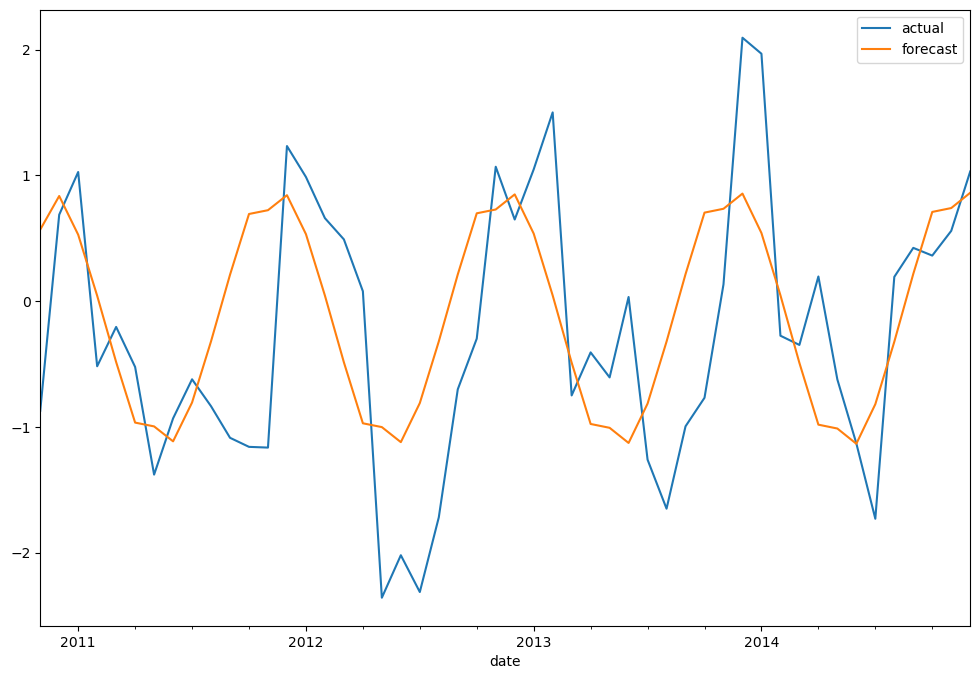

In [29]:
LF.prediction(50)

In [30]:
LF.errors()

MAPE: 199.04 
 MAD: 74.44
